# Hamilton House Price Prediction: Spatial vs. Non-Spatial Regression Methods

### 1. Problem Definition
The goal of this problem is to explore **house price prediction** using spatial and non-spatial regression techniques on Hamilton, ON house pricing data.

We are going to be training various machine learning regression algorithms and spatial regression algorithms with a number of different **house features** to predict house prices.

In a statement,
> **Research Question:** Will the Spatial Regression model provide better predictions than the Mahcine Learning Model for house price prediction?:


### 2. Data 
The data was collected from the 2016 Canadian census tract database through the [University of Toronto's CHASS Data Centre](https://datacentre.chass.utoronto.ca/). We randomly selected 10 features (housing attributes) from Hamilton's census tract data that we believe would influence house prices. 

The dataset contains 10 features and 187 observations. Each observation represents the data for a single census tract in the city of Hamilton, ON.

Additionally, a GeoJSON file containing the corresponding house prices as well as GeoID and CTUID numbers for each census tract will be merged to the predictors collected from the CHASS Data Centre. This will create a spatial dataset that can be used for spatial analysis and machine learning. 

The **indepedent variables (features)** in this dataset are various housing attributes, and the **dependent variable (target)** is the house prices. 

### 3. Evaluation
> Will the spatial regression models provide higher R^2 values with lower RMSEs value than the machine learning regression algorithms?

### 4. Features

**Hamilton House Prices Data Dictionary**

The following features are going to be used to predict the target variable (house price values):
* **1. priv_dwellings_by_bedroom** - Occupied private homes by # of bedrooms
* **2. priv_dwellings_by_room** - Occupied private homes by # of rooms
* **3. major_repairs** - Major repairs needed for property
* **4. monthly_housing_costs** - Monthly housing costs
* **5. percent_mortgage** - Percentages of individuals with mortgages
* **6. income_after_tax** - After-tax income
* **7. house_by_person_per_room** - Private households by # of persons per room
* **8. avg_house_size** - Average household size (number of people)
* **9. population** - Population by geographic area/block
* **10. land_area** - Land area in square kilometers per geographic area/block
* **11. houseValue** - Average house value per census tract in CAD dollars

### 5. Preparing the Tools

In [174]:
# Importing EDA and Plotting Libraries
import pandas as pd
from pandas import set_option
from pandas.plotting import scatter_matrix
import numpy as np
from scipy import stats
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
# plots should appear in the notebook
%matplotlib inline 
import seaborn as sns

# Visualization themes & styles
plt.style.use('ggplot')
sns.set_theme(style = "darkgrid", palette = "pastel")

# Importing Spatial Analysis Libraries
import geopandas as gpd
from pysal.model import spreg
from pysal.lib import weights

# Regression Models for Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Regression Model Tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### 6. Load Data

In [2]:
# Hamilton House Pricing & Boundary Data
url = "https://raw.githubusercontent.com/gisUTM/GGR376/master/Lab_1/houseValues.geojson"
house_prices_boundaries = gpd.read_file(url)
house_prices_boundaries.head(5)

,CTUID,houseValue,geometry
0,5370001.09,420276.0,"POLYGON ((-79.85586 43.18790, -79.85592 43.187..."
1,5370120.02,601551.0,"POLYGON ((-79.94562 43.16920, -79.94637 43.167..."
2,5370140.03,525073.0,"POLYGON ((-79.89977 43.33088, -79.89977 43.330..."
3,5370140.04,524777.0,"POLYGON ((-79.89286 43.32909, -79.89226 43.328..."
4,5370001.08,400617.0,"POLYGON ((-79.85362 43.19320, -79.85380 43.192..."


In [3]:
# Hamilton Housing Features Data
house_attributes = pd.read_csv("hamilton_census_data.csv")
house_attributes.head(5)

,CTUID,priv_dwellings_by_bedroom,priv_dwellings_by_rooms,major_repairs,monthly_housing_costs,percent_mortgage,income_after_tax,house_by_person_per_room,avg_house_size,population,land_area
0,5370000.00,293345,293345,18370,1294,60.6,66100,293345,2.5,747545,1371.89
1,5370001.01,760,760,35,1269,57.9,69530,760,2.9,2193,5.52
2,5370001.02,1760,1760,70,1493,70.2,72590,1755,3.0,5302,1.29
3,5370001.04,1900,1895,50,1367,59.7,83257,1895,3.3,6305,1.70
4,5370001.05,1605,1610,45,1569,65.3,75136,1605,3.2,5344,1.55


In [4]:
# Merge Features Data & House Pricing/Boundary Data 
df = house_prices_boundaries.merge(house_attributes, on = "CTUID")
df.head(5)

,CTUID,houseValue,geometry,priv_dwellings_by_bedroom,priv_dwellings_by_rooms,major_repairs,monthly_housing_costs,percent_mortgage,income_after_tax,house_by_person_per_room,avg_house_size,population,land_area
0,5370001.09,420276.0,"POLYGON ((-79.85586 43.18790, -79.85592 43.187...",1390,1390,25,1612,72.3,78976,1395,3.3,4566,1.97
1,5370120.02,601551.0,"POLYGON ((-79.94562 43.16920, -79.94637 43.167...",690,685,75,1460,55.5,87211,685,3.0,7821,27.69
2,5370140.03,525073.0,"POLYGON ((-79.89977 43.33088, -79.89977 43.330...",2505,2505,50,1883,78.3,98624,2505,2.8,5879,2.37
3,5370140.04,524777.0,"POLYGON ((-79.89286 43.32909, -79.89226 43.328...",1320,1315,25,1705,63.5,94948,1320,3.0,8605,10.22
4,5370001.08,400617.0,"POLYGON ((-79.85362 43.19320, -79.85380 43.192...",2050,2050,35,1513,66.7,80576,2055,3.2,6556,1.64


### 7. Exploratory Data Analysis (EDA)
EDA Template that will be followed for this problem:
1. What question(s) are you trying to solve (or prove wrong)?
2. What kind of data do you have and what are the different types of data present?
3. What's missing from the data and how do you deal with it?
4. Where are the outliers and are they something to be concerned about?
5. How can you add, change or remove features to get more out of your data?

#### 7.1 Data Description

In [5]:
# Top 10 rows of dataframe
df.head(10)

,CTUID,houseValue,geometry,priv_dwellings_by_bedroom,priv_dwellings_by_rooms,major_repairs,monthly_housing_costs,percent_mortgage,income_after_tax,house_by_person_per_room,avg_house_size,population,land_area
0,5370001.09,420276.0,"POLYGON ((-79.85586 43.18790, -79.85592 43.187...",1390,1390,25,1612,72.3,78976,1395,3.3,4566,1.97
1,5370120.02,601551.0,"POLYGON ((-79.94562 43.16920, -79.94637 43.167...",690,685,75,1460,55.5,87211,685,3.0,7821,27.69
2,5370140.03,525073.0,"POLYGON ((-79.89977 43.33088, -79.89977 43.330...",2505,2505,50,1883,78.3,98624,2505,2.8,5879,2.37
3,5370140.04,524777.0,"POLYGON ((-79.89286 43.32909, -79.89226 43.328...",1320,1315,25,1705,63.5,94948,1320,3.0,8605,10.22
4,5370001.08,400617.0,"POLYGON ((-79.85362 43.19320, -79.85380 43.192...",2050,2050,35,1513,66.7,80576,2055,3.2,6556,1.64
5,5370223.09,674299.0,"POLYGON ((-79.78562 43.39827, -79.78568 43.398...",2685,2690,35,2052,83.0,109391,2685,3.0,4577,2.49
6,5370223.10,598768.0,"POLYGON ((-79.79016 43.39399, -79.79036 43.393...",1580,1580,10,1834,78.6,96293,1580,2.6,3157,0.98
7,5370223.12,449485.0,"POLYGON ((-79.78571 43.36864, -79.78664 43.367...",3585,3590,135,1473,69.3,70326,3585,3.2,3954,1.44
8,5370055.00,240132.0,"POLYGON ((-79.80015 43.23902, -79.80054 43.238...",1275,1280,155,1054,70.0,53555,1275,2.2,3120,0.50
9,5370069.00,179211.0,"POLYGON ((-79.78823 43.27508, -79.78661 43.273...",400,400,30,974,90.9,46848,395,2.2,1855,2.37


In [6]:
# Shape of dataframe
print(df.shape)

(187, 13)


This dataset contains 187 observations/census districts in Hamilton, ON (the rows), and each observation/census district in Hamilton is accompanied with 13 housing attributes/features (columns) about them that are related to house pricing. 

#### 7.2 Descriptive Statistics

In [7]:
# Data types
df.dtypes

CTUID                         float64
houseValue                    float64
geometry                     geometry
priv_dwellings_by_bedroom       int64
priv_dwellings_by_rooms         int64
major_repairs                   int64
monthly_housing_costs           int64
percent_mortgage              float64
income_after_tax                int64
house_by_person_per_room        int64
avg_house_size                float64
population                      int64
land_area                     float64
dtype: object

In [8]:
# Number of unique values in each column for the features data
dict = {}
for i in list(house_attributes.columns):
    dict[i] = house_attributes[i].value_counts().shape[0]

pd.DataFrame(dict, index = ["# of Unique Values:"]).transpose()

,# of Unique Values:
CTUID,188
priv_dwellings_by_bedroom,164
priv_dwellings_by_rooms,155
major_repairs,52
monthly_housing_costs,167
percent_mortgage,155
income_after_tax,182
house_by_person_per_room,159
avg_house_size,21
population,184


After inspecting unique values, it is safe to conclude that we do not have any repeating census districts in our data.

In [9]:
# Seperating the columns into categorical, continous and spatial features
categorical_cols = ["CTUID"]
continuous_cols = ["priv_dwellings_by_bedroom", "priv_dwellings_by_rooms", "major_repairs", "monthly_housing_costs", "percent_mortgage", "income_after_tax", "house_by_person_per_room", "avg_house_size", "population", "land_area"]
spatial_cols = ["geometry"]
target_col = ["houseValue"]

In [10]:
# Summary Statistics for features
df[continuous_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
priv_dwellings_by_bedroom,187.0,1551.096257,675.297029,45.00,1085.000,1410.0,1970.000,3585.00
priv_dwellings_by_rooms,187.0,1551.149733,675.453364,45.00,1085.000,1415.0,1970.000,3590.00
major_repairs,187.0,97.165775,69.089620,0.00,50.000,75.0,135.000,395.00
monthly_housing_costs,187.0,1241.331551,280.319992,686.00,1025.500,1201.0,1440.500,2263.00
percent_mortgage,187.0,59.420321,10.941104,0.00,52.000,59.2,67.700,90.90
income_after_tax,187.0,68376.438503,22060.550335,20320.00,50533.500,67157.0,84317.000,128213.00
house_by_person_per_room,187.0,1551.096257,675.429972,45.00,1085.000,1415.0,1970.000,3585.00
avg_house_size,187.0,2.503209,0.408894,1.30,2.200,2.5,2.800,3.40
population,187.0,3862.160428,1871.094716,0.00,2612.000,3549.0,4622.000,10637.00
land_area,187.0,7.213636,19.724983,0.32,0.855,1.4,2.525,137.49


In [11]:
# Summary Statistics for target (House Prices)
df[target_col].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
houseValue,187.0,428997.080214,153776.273172,160515.0,320617.5,400757.0,521803.5,946729.0


In [12]:
# Correlation between features and target
set_option('precision', 2)
print(df.corr(method = "pearson"))

                              CTUID  houseValue  priv_dwellings_by_bedroom  \
CTUID                      1.00e+00        0.63                       0.18   
houseValue                 6.31e-01        1.00                       0.06   
priv_dwellings_by_bedroom  1.81e-01        0.06                       1.00   
priv_dwellings_by_rooms    1.81e-01        0.06                       1.00   
major_repairs             -2.17e-01       -0.48                       0.42   
monthly_housing_costs      4.12e-01        0.55                       0.29   
percent_mortgage          -9.58e-03       -0.27                       0.16   
income_after_tax           4.93e-01        0.80                       0.06   
house_by_person_per_room   1.81e-01        0.06                       1.00   
avg_house_size             1.52e-01        0.23                       0.09   
population                 1.52e-01        0.23                       0.15   
land_area                  2.10e-01        0.27                 

Interestingly, some attributes have a strong correlation (>0.70 or <-0.70) and some attributes have a 1.0 correlation.
* priv_dwellings_by_bedroom and priv_dwellings_by_rooms with 1.00
* priv_dwellings_by_bedroom and house_by_person_per_room with 1.00
* priv_wellings_by_rooms and house_by_person_per_room with 1.00
* The remaining variables are uncorrelated in negative and postive directions.

#### 7.3 Handling Missing Values & Duplicates

In [13]:
# Number of missing values
df.isnull().sum()

CTUID                        0
houseValue                   0
geometry                     0
priv_dwellings_by_bedroom    0
priv_dwellings_by_rooms      0
major_repairs                0
monthly_housing_costs        0
percent_mortgage             0
income_after_tax             0
house_by_person_per_room     0
avg_house_size               0
population                   0
land_area                    0
dtype: int64

There are **no missing values** in this dataset!

In [14]:
# Number of duplicates
duplicates_number = df.duplicated().sum()
print("Number of duplicated rows is: ", duplicates_number)

Number of duplicated rows is:  0


There are **no duplicate values** in this dataset!

#### 7.4 Data Visualizations
  ##### 7.4.1 Univariate Data Visualizations

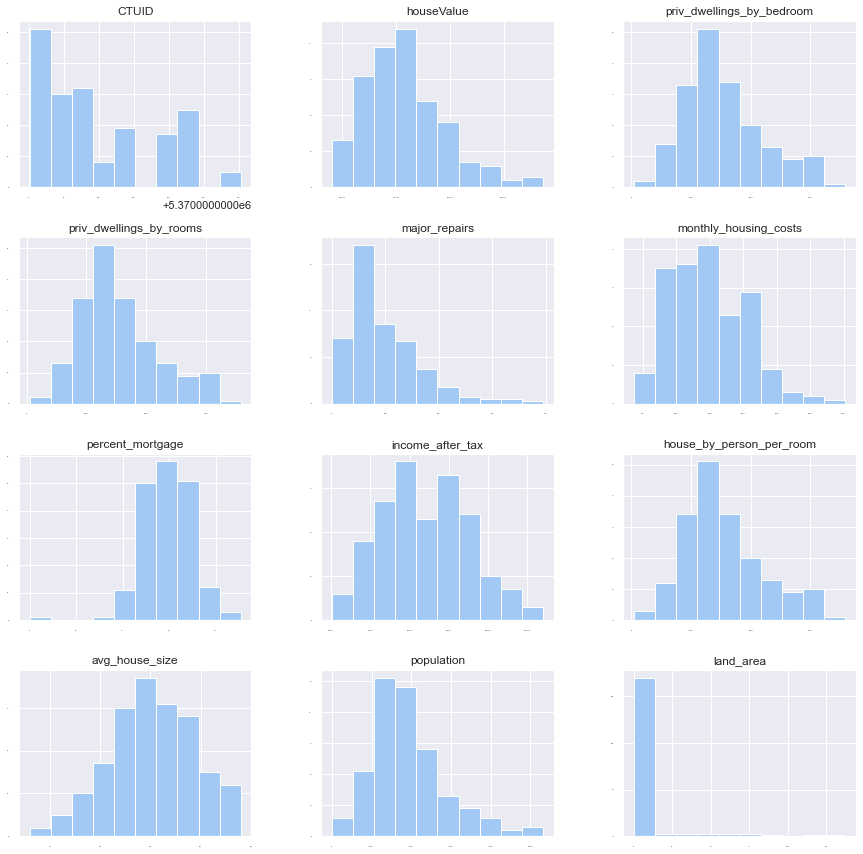

In [15]:
# Histograms
histograms = df.hist(sharex = False, sharey = False, xlabelsize = 2, ylabelsize = 2, figsize = (15, 15));

Most of our features appear to be uniform with some level of skew, specifically the `land_area` and `major_repairs` appear to skewed. The distribution of the `CTUID` feature does not matter as this is actually a ordinal feature.

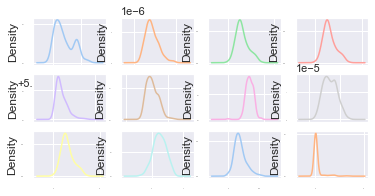

In [16]:
# Density Plots
df.plot(kind = "density", subplots = True, layout = (4, 4), sharex = False, legend = False, fontsize = 1);

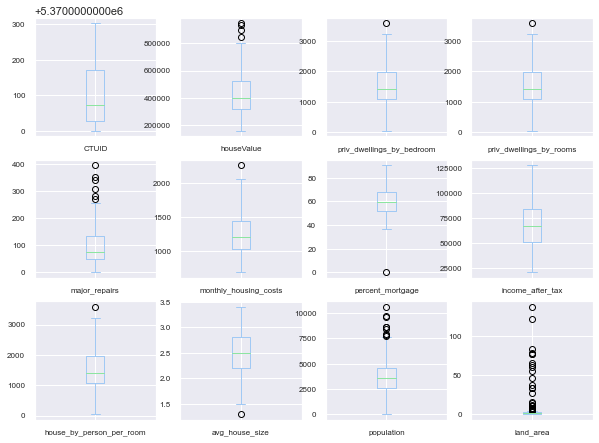

In [17]:
# Box and Whisker Plots
df.plot(kind = "box", subplots = True, layout = (4, 4), sharex = False, sharey = False, fontsize = 8, figsize = (10, 10));

 ##### 7.4.2 Multivariate Data Visualizations

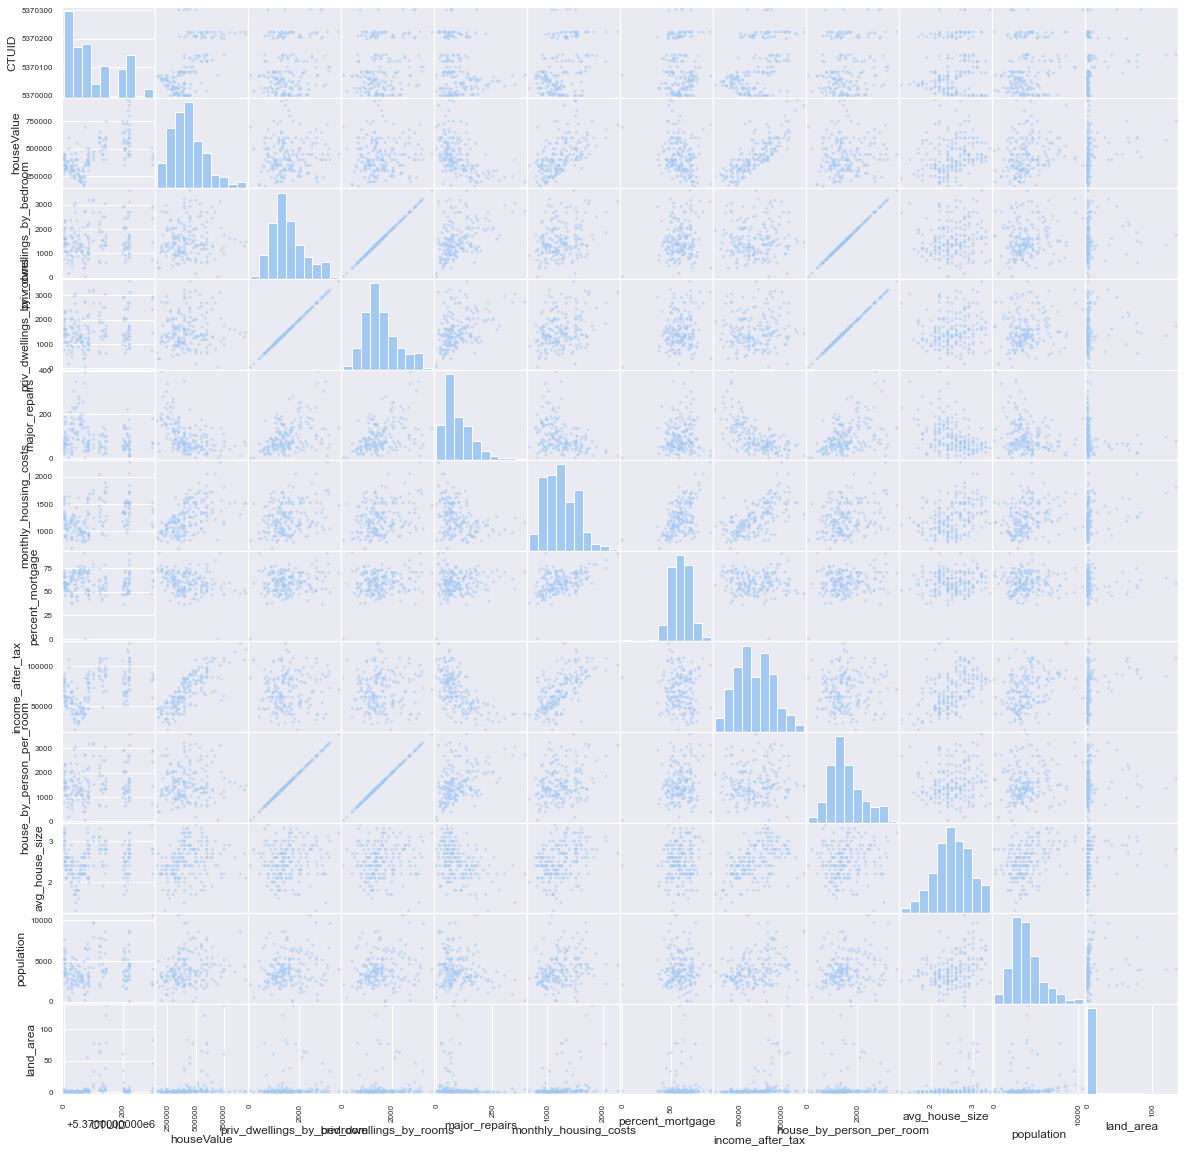

In [18]:
# Scatter plot matrix
scatter_matrix(df, figsize = (20, 20));

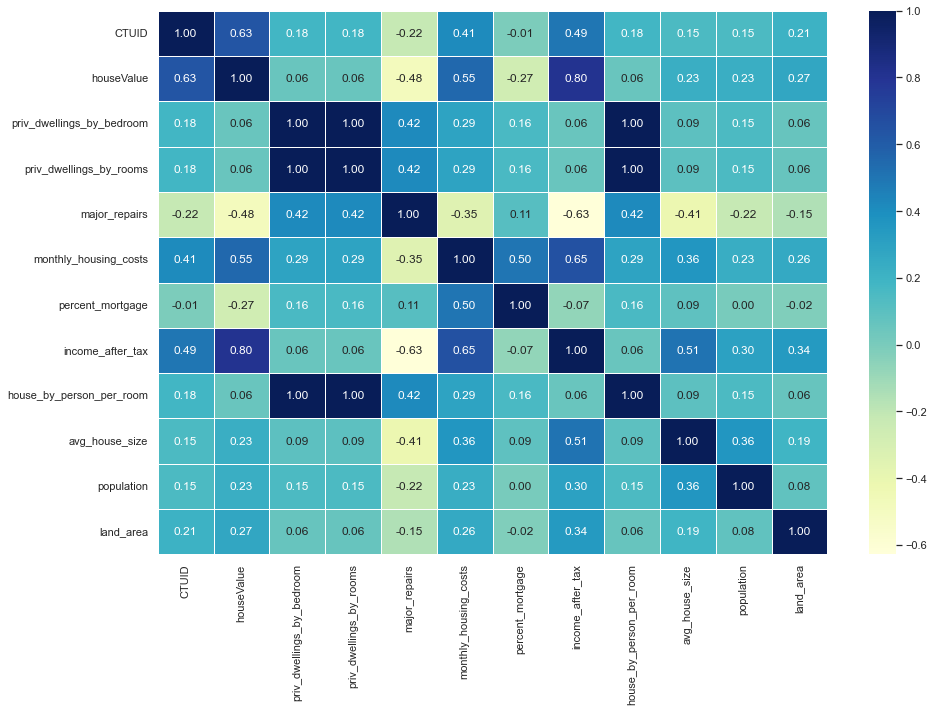

In [19]:
# Heatmap Matrix
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

**Conclusions from Correlation Analysis:** The correlation matrix confirms that features `priv_dwellings_by_bedroom`, `priv_dwellings_byrooms` and `house_by_person_per_room` are postively correlated with a 1.0 correlation coefficient. Two of these features will be removed and only one of them will be kept for analysis. Since all features have the same correlation coefficient with the target variable `houseValue`, keeping the `priv_dwellings_byrooms` feature makes the most sense as it represents the occupied private homes by the number of rooms per household. 

In [20]:
# Dropping Correlated Features
df_copy = df.drop(labels = ["priv_dwellings_by_bedroom", "house_by_person_per_room"], axis = 1)
df_copy.head(5).T

,0,1,2,3,4
CTUID,5370001.09,5370120.02,5370140.03,5370140.04,5370001.08
houseValue,420276.0,601551.0,525073.0,524777.0,400617.0
geometry,POLYGON ((-79.85585608623806 43.18790480765137...,POLYGON ((-79.94561572042278 43.16919707961404...,POLYGON ((-79.89977479297787 43.33088328674891...,POLYGON ((-79.89286498587246 43.32909149897649...,POLYGON ((-79.8536157883761 43.193195107406744...
priv_dwellings_by_rooms,1390,685,2505,1315,2050
major_repairs,25,75,50,25,35
monthly_housing_costs,1612,1460,1883,1705,1513
percent_mortgage,72.3,55.5,78.3,63.5,66.7
income_after_tax,78976,87211,98624,94948,80576
avg_house_size,3.3,3.0,2.8,3.0,3.2
population,4566,7821,5879,8605,6556


##### 7.4.4 Exploring Target Variable

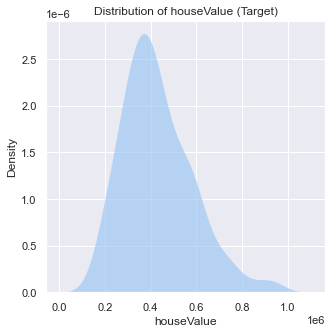

In [21]:
# Density Plot of Target
fig, ax = plt.subplots(figsize = (5, 5))
sns.kdeplot(data = df, x = 'houseValue', fill = True, alpha = 0.7, linewidth = 0)
ax.set_title("Distribution of houseValue (Target)");

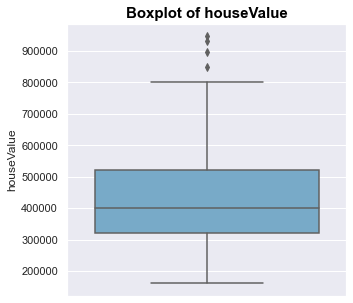

In [22]:
# Boxplot of Target
fig, ax = plt.subplots(figsize = (5, 5))
sns.boxplot(y = df['houseValue'], palette = 'Blues')
ax.set_title('Boxplot of houseValue', fontdict={'fontsize': 15, 'fontweight': 'bold', 'color': '000000'});

There are **outliers** present in the target variable, `houseValue`, so IQR will be used to inspect and remove these outliers.

In [23]:
# Using IQR to inspect outliers
houseValue_stats = df_copy['houseValue'].describe()
IQR = houseValue_stats['75%'] - houseValue_stats['25%']
upper_bound = houseValue_stats['75%'] + 1.5 * IQR
lower_bound = houseValue_stats['25%'] - 1.5 * IQR
print("The upper and lower bounds for the targer are: ", (upper_bound, lower_bound))

The upper and lower bounds for the targer are:  (823582.5, 18838.5)


In [24]:
# Examine the outliers below the lower bound of house prices
df_copy[df_copy['houseValue'] < lower_bound]

,CTUID,houseValue,geometry,priv_dwellings_by_rooms,major_repairs,monthly_housing_costs,percent_mortgage,income_after_tax,avg_house_size,population,land_area


There **no outliers** below the lower bound of house prices in this dataset. 

In [25]:
# Examine the outliers above the upper bound of house prices
df_copy[df_copy['houseValue'] > upper_bound]

,CTUID,houseValue,geometry,priv_dwellings_by_rooms,major_repairs,monthly_housing_costs,percent_mortgage,income_after_tax,avg_house_size,population,land_area
57,5.37e+06,946729.0,"POLYGON ((-79.76999 43.33381, -79.77480 43.330...",1475,60,1515,48.2,120192,2.1,2621,1.08
59,5.37e+06,848338.0,"POLYGON ((-79.75641 43.34332, -79.75688 43.343...",1585,55,1528,51.0,117931,2.6,3615,2.18
101,5.37e+06,933019.0,"POLYGON ((-79.86775 43.45767, -79.86734 43.457...",1300,75,1505,51.1,107264,2.7,4300,1.58
107,5.37e+06,897155.0,"POLYGON ((-79.80862 43.39892, -79.80810 43.398...",1440,10,1309,47.9,128213,2.2,8665,2.85


There are **4 outliers** above the upper bound of house prices in this dataset. Lets explore the features of census tracts that have average house prices above $700,000 to see if there is any difference in any of the features. It is possible that these census tracts have more expensive homes because size or location. If this is the case, we do not want to remove these census tracts as they are not significantly more expensive than the other tracts, and this data will prove the importance of spatial features when doing the spatial regression modelling if their location is what is influencing the price.

In [26]:
# Inspect the number of census tracts where average house price is greater than $700,000
df_copy[df_copy['houseValue'] > 700000]

,CTUID,houseValue,geometry,priv_dwellings_by_rooms,major_repairs,monthly_housing_costs,percent_mortgage,income_after_tax,avg_house_size,population,land_area
43,5.37e+06,752941.0,"POLYGON ((-79.85090 43.34609, -79.85052 43.345...",980,55,1181,46.7,106240,2.9,5161,60.89
48,5.37e+06,727776.0,"POLYGON ((-79.81927 43.31236, -79.81901 43.312...",1130,35,1367,52.0,83627,2.1,3605,6.17
54,5.37e+06,727500.0,"POLYGON ((-79.79442 43.33251, -79.79294 43.331...",2040,135,1560,55.0,56768,2.2,3012,1.75
56,5.37e+06,750491.0,"POLYGON ((-79.78065 43.32785, -79.78455 43.325...",1245,110,1126,46.8,62272,2.2,3814,0.80
57,5.37e+06,946729.0,"POLYGON ((-79.76999 43.33381, -79.77480 43.330...",1475,60,1515,48.2,120192,2.1,2621,1.08
59,5.37e+06,848338.0,"POLYGON ((-79.75641 43.34332, -79.75688 43.343...",1585,55,1528,51.0,117931,2.6,3615,2.18
98,5.37e+06,753068.0,"POLYGON ((-79.93861 43.40264, -79.93799 43.402...",1750,75,1804,58.4,109568,2.8,4004,137.49
101,5.37e+06,933019.0,"POLYGON ((-79.86775 43.45767, -79.86734 43.457...",1300,75,1505,51.1,107264,2.7,4300,1.58
106,5.37e+06,800736.0,"POLYGON ((-79.79515 43.39722, -79.79196 43.394...",1620,40,1511,59.2,104661,2.9,4428,1.21
107,5.37e+06,897155.0,"POLYGON ((-79.80862 43.39892, -79.80810 43.398...",1440,10,1309,47.9,128213,2.2,8665,2.85


These 4 outlier census tracts will be **kept** as there 11 census tracts with average house prices above $700,000, and their attributes (features) seem to be consistent. It is likely that these census tracts are more expensive because of location, and how new/well-developed these houses are. 

##### 7.4.3 Chloropleth Maps

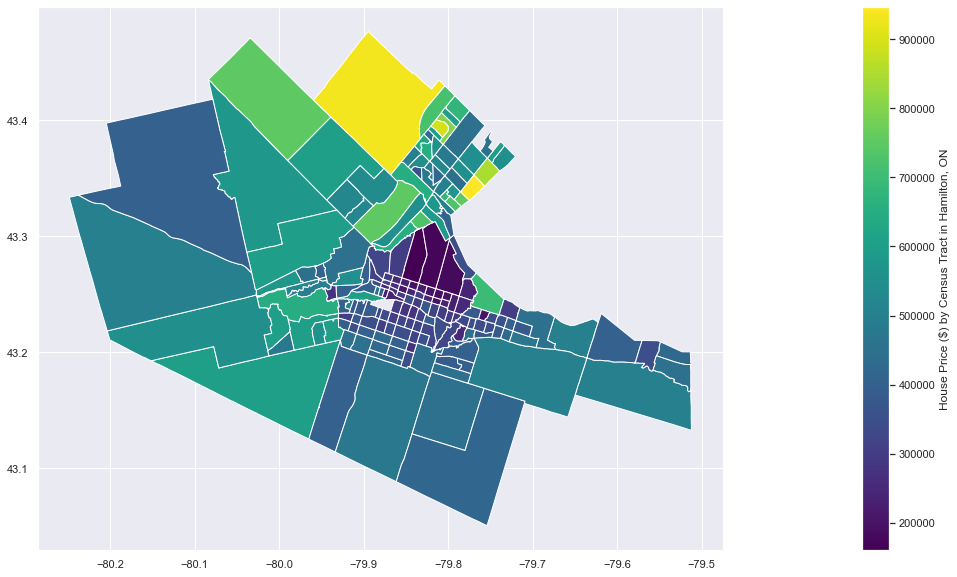

In [27]:
# Chloropleth Map of house value by census tract
df_copy.plot(column = "houseValue",
           legend = True,
           figsize = [50, 10],
           legend_kwds = {'label': "House Price ($) by Census Tract in Hamilton, ON"},
           cmap = "viridis");

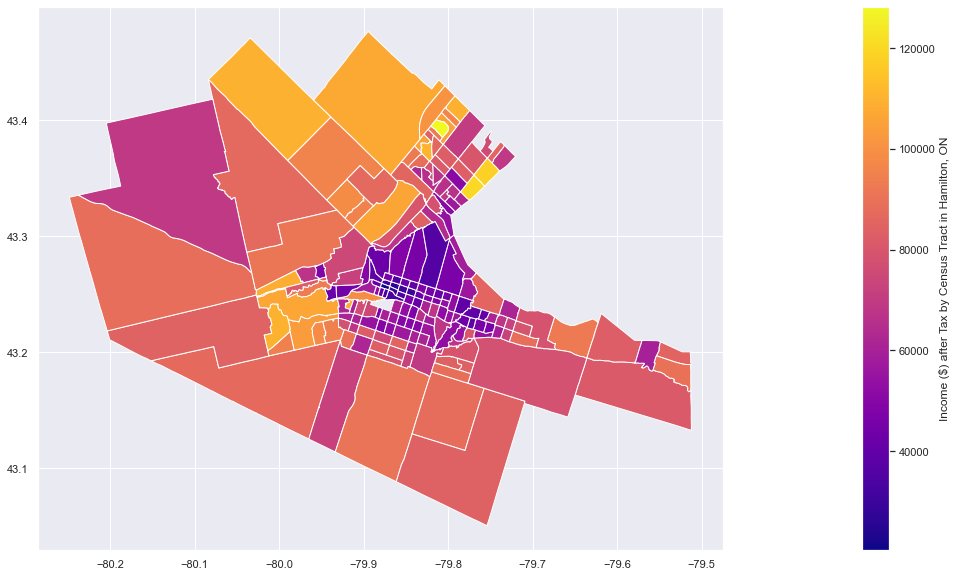

In [29]:
# Chloropleth Map of income per household by census tract
df_copy.plot(column = "income_after_tax",
           legend = True,
           figsize = [50, 10],
           legend_kwds = {'label': "Income ($) after Tax by Census Tract in Hamilton, ON"},
           cmap = "plasma");

### 10. Data Preprocessing

#### 10.1 Defining the Features and Target

In [30]:
# Inspecting the dataframe again
df_copy.head(5)

,CTUID,houseValue,geometry,priv_dwellings_by_rooms,major_repairs,monthly_housing_costs,percent_mortgage,income_after_tax,avg_house_size,population,land_area
0,5.37e+06,420276.0,"POLYGON ((-79.85586 43.18790, -79.85592 43.187...",1390,25,1612,72.3,78976,3.3,4566,1.97
1,5.37e+06,601551.0,"POLYGON ((-79.94562 43.16920, -79.94637 43.167...",685,75,1460,55.5,87211,3.0,7821,27.69
2,5.37e+06,525073.0,"POLYGON ((-79.89977 43.33088, -79.89977 43.330...",2505,50,1883,78.3,98624,2.8,5879,2.37
3,5.37e+06,524777.0,"POLYGON ((-79.89286 43.32909, -79.89226 43.328...",1315,25,1705,63.5,94948,3.0,8605,10.22
4,5.37e+06,400617.0,"POLYGON ((-79.85362 43.19320, -79.85380 43.192...",2050,35,1513,66.7,80576,3.2,6556,1.64


The spatial attributes of the dataframe are not required for data preprocessing as the modelling (non-spatial machine learning) will done on `target variable`, the house prices, and the `features`, housing attributes. Therefore, another copy of the dataframe will be made that only selects the housing features, and house prices while dropping the spatial attributes, `CTUID` and `geometry`.

In [31]:
# Non-spatial data (selecting target and house features)
df_non_spatial = df_copy.drop(labels = ["CTUID", "geometry"], axis = 1)
df_non_spatial.head(5).T

,0,1,2,3,4
houseValue,420276.00,601551.00,525073.00,524777.00,400617.00
priv_dwellings_by_rooms,1390.00,685.00,2505.00,1315.00,2050.00
major_repairs,25.00,75.00,50.00,25.00,35.00
monthly_housing_costs,1612.00,1460.00,1883.00,1705.00,1513.00
percent_mortgage,72.30,55.50,78.30,63.50,66.70
income_after_tax,78976.00,87211.00,98624.00,94948.00,80576.00
avg_house_size,3.30,3.00,2.80,3.00,3.20
population,4566.00,7821.00,5879.00,8605.00,6556.00
land_area,1.97,27.69,2.37,10.22,1.64


In [32]:
# Split the data into X and y
X = df_non_spatial.drop("houseValue", axis = 1)

y = df_non_spatial["houseValue"]

In [33]:
# Indepdent variables (features/housing attributes)
X.head(5)

,priv_dwellings_by_rooms,major_repairs,monthly_housing_costs,percent_mortgage,income_after_tax,avg_house_size,population,land_area
0,1390,25,1612,72.3,78976,3.3,4566,1.97
1,685,75,1460,55.5,87211,3.0,7821,27.69
2,2505,50,1883,78.3,98624,2.8,5879,2.37
3,1315,25,1705,63.5,94948,3.0,8605,10.22
4,2050,35,1513,66.7,80576,3.2,6556,1.64


In [34]:
# Target variable (house prices)
y

0      420276.0
1      601551.0
2      525073.0
3      524777.0
4      400617.0
         ...   
182    538708.0
183    600322.0
184    449271.0
185    500508.0
186    400081.0
Name: houseValue, Length: 187, dtype: float64

#### 10.1 Training and Test Split

In [35]:
# Set random seed for consistency and reproducibility
np.random.seed(42)

# Split data into train & sets
X_train, X_test, y_train, y_test = train_test_split(X, # independent variables
                                                    y, # dependent variable
                                                    test_size = 0.2) # percentage of data to use for test set

# Sizes of test & training sets
# Sizes of test & training sets
print("The shape of X_train is:", X_train.shape)
print("The shape of X_test is: ", X_test.shape)
print("The shape of y_train is:", y_train.shape)
print("The shape of y_test is: ", y_test.shape)

The shape of X_train is: (149, 8)
The shape of X_test is:  (38, 8)
The shape of y_train is: (149,)
The shape of y_test is:  (38,)


### 11. Modelling (Non-Spatial Machine Learning)

#### 11.1 Model Choices
Now that the data has been prepared for modelling, we can start to fit the models. We will be using the following models, and their results will be compared:
1. LinearRegression()
2. Lasso()
3. ElasticNet()
4. DecisionTreeRegressor()
5. KNeighborsRegressor()
6. SVR()
7. AdaBoostRegressor()
8. GradientBoostingRegressor()
9. RandomForestRegressor()
10. ExtraTreeRegressor()

**Why these?**

We selected these models through the help of the [Scikit-Learn algorithm cheat sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html). Since this is a **regression** a problem with 187 observations, and we are not sure if only a few of the features are important, the documentation suggests the usage of:
* Lasso
* Elastic Net
* Ridge Regression
* SVR (Kernel = 'linear')
* SVR (kernel = 'rbf')
* Ensemble Regressors

In [36]:
df.shape

(187, 13)

In [37]:
# Put models in a dictionary
models = {"Linear Regression": LinearRegression(),
          "Lasso": Lasso(),
          "Elastic Net": ElasticNet(),
          "Decision Tree Regressor": DecisionTreeRegressor(),
          "KNN Regressor": KNeighborsRegressor(),
          "SVR": SVR(),
          "AdaBoost": AdaBoostRegressor(),
          "Gradient Boost": GradientBoostingRegressor(),
          "Random Forest": RandomForestRegressor(),
          "Extra Trees Regressor": ExtraTreesRegressor()}

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning mdoels.
    models: a dict of different Scikit-Learn machine learning models
    X_train: training data
    X_test: testing data
    y_train: labels associated with training data
    y_test: labels associated with test data
    """
    # Random seed for consistent and reproducible results
    np.random.seed(42)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [38]:
# Obtain scores for models
model_scores = fit_and_score(models = models,
                             X_train = X_train,
                             X_test = X_test,
                             y_train = y_train,
                             y_test = y_test)
model_scores

{'Linear Regression': 0.727876721495349,
 'Lasso': 0.727868675049306,
 'Elastic Net': 0.6672882702918936,
 'Decision Tree Regressor': 0.5376145152372565,
 'KNN Regressor': 0.6354111635607999,
 'SVR': -0.0019016636150115396,
 'AdaBoost': 0.37378328851048404,
 'Gradient Boost': 0.6233399425178301,
 'Random Forest': 0.7096205718043888,
 'Extra Trees Regressor': 0.7228489941597072}

#### 11.2 Model Comparison

In [39]:
# Put models into dataframe for comparison
model_compare = pd.DataFrame(model_scores, index = ["R^2"])
model_compare

,Linear Regression,Lasso,Elastic Net,Decision Tree Regressor,KNN Regressor,SVR,AdaBoost,Gradient Boost,Random Forest,Extra Trees Regressor
R^2,0.73,0.73,0.67,0.54,0.64,-1.90e-03,0.37,0.62,0.71,0.72


                                                      Model Comparison:                                                      
                                               _______________________________                                               


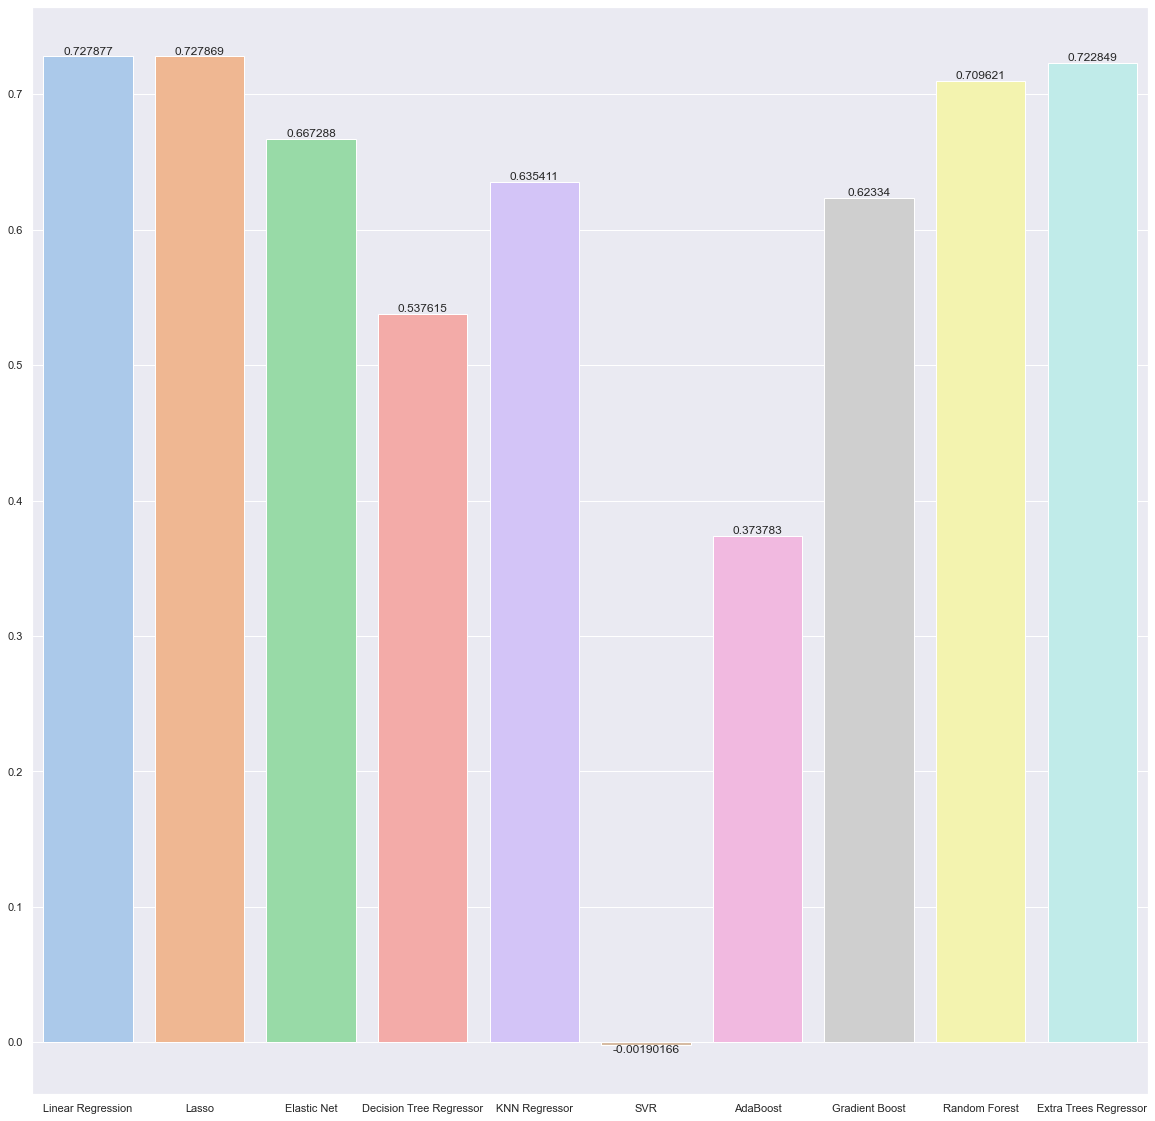

In [40]:
# Visualize model results
# Title for Model Comparison Bar Plot
title_graph = "Model Comparison:"
centered_title = title_graph.center(125)
underline = "_______________________________"
centered_underline = underline.center(125)
print(centered_title)
print(centered_underline)

# Plot model results
plt.figure(figsize = (20, 20))
model_plot = sns.barplot(data = model_compare)
model_plot.bar_label(model_plot.containers[0]); # Make bar values appear on bars

**Inference:** 
* From the baseline models, it is apparent that the best performing models are `LinearRegression()`, `Lasso()`, `RandomForest()`, `ExtraTreesRegressor()`. All 4 of these models achieved an R^2 value (Coefficient of Determination) greater than 0.7.
* `SVR()` and `AdaBoostingRegressor()` had the worst performances with `SVR()` having a negative R^2 model!
* We suspect that the raw data is likely impacting the performance of some algorithms negatively, so **standardization** of the data is required. 

#### 11.3 Data Standardization
To counter the different scales of the features (example: `income_after_tax` and `land_area`), **feature scaling** is required.

In [41]:
# Standardize features (independent variables)
scale = StandardScaler()
standard_X = scale.fit_transform(X)
standard_X

array([[-0.23922059, -1.04732823,  1.32585454, ...,  1.95388371,
         0.37717443, -0.26655097],
       [-1.285766  , -0.3216877 ,  0.78216141, ...,  1.21822683,
         2.12146788,  1.04087967],
       [ 1.41595408, -0.68450796,  2.29520216, ...,  0.7277889 ,
         1.0807865 , -0.24621767],
       ...,
       [ 0.83701406, -0.46681581,  1.29723911, ...,  0.97300786,
        -0.89232825,  2.42506849],
       [-0.32828828,  0.04113256,  1.04685412, ...,  0.48256994,
        -0.12226689, -0.21266774],
       [ 0.10220558, -0.82963607, -1.16011077, ...,  0.97300786,
         0.07011447,  1.56192027]])

In [42]:
# Re-setup training and test set with standardized features
np.random.seed(42)

# Split data into train & sets
standard_X_train, standard_X_test, standard_y_train, standard_y_test = train_test_split(standard_X, # independent variables
                                                    y, # dependent variable
                                                    test_size = 0.2) # percentage of data to use for test set

# Sizes of test & training sets
# Sizes of test & training sets
print("The shape of standard_X_train is:", standard_X_train.shape)
print("The shape of standard_X_test is: ", standard_X_test.shape)
print("The shape of standard_y_train is:", standard_y_train.shape)
print("The shape of standard_y_test is: ", standard_y_test.shape)

The shape of standard_X_train is: (149, 8)
The shape of standard_X_test is:  (38, 8)
The shape of standard_y_train is: (149,)
The shape of standard_y_test is:  (38,)


In [43]:
# Obtain scores for models
standard_model_scores = fit_and_score(models = models,
                             X_train = standard_X_train,
                             X_test = standard_X_test,
                             y_train = standard_y_train,
                             y_test = standard_y_test)
standard_model_scores

{'Linear Regression': 0.7278767214953588,
 'Lasso': 0.7279046916901117,
 'Elastic Net': 0.7855917413231832,
 'Decision Tree Regressor': 0.5376145152372565,
 'KNN Regressor': 0.49477772896645755,
 'SVR': -0.0019911200454321154,
 'AdaBoost': 0.3505650807987357,
 'Gradient Boost': 0.6319521565528814,
 'Random Forest': 0.7153131638331285,
 'Extra Trees Regressor': 0.7228489941597072}

In [44]:
# Put standardized models into dataframe for comparison
standard_model_compare = pd.DataFrame(standard_model_scores, index = ["R^2"])
standard_model_compare

,Linear Regression,Lasso,Elastic Net,Decision Tree Regressor,KNN Regressor,SVR,AdaBoost,Gradient Boost,Random Forest,Extra Trees Regressor
R^2,0.73,0.73,0.79,0.54,0.49,-1.99e-03,0.35,0.63,0.72,0.72


                                                Standardized Model Comparison:                                               
                                               _______________________________                                               


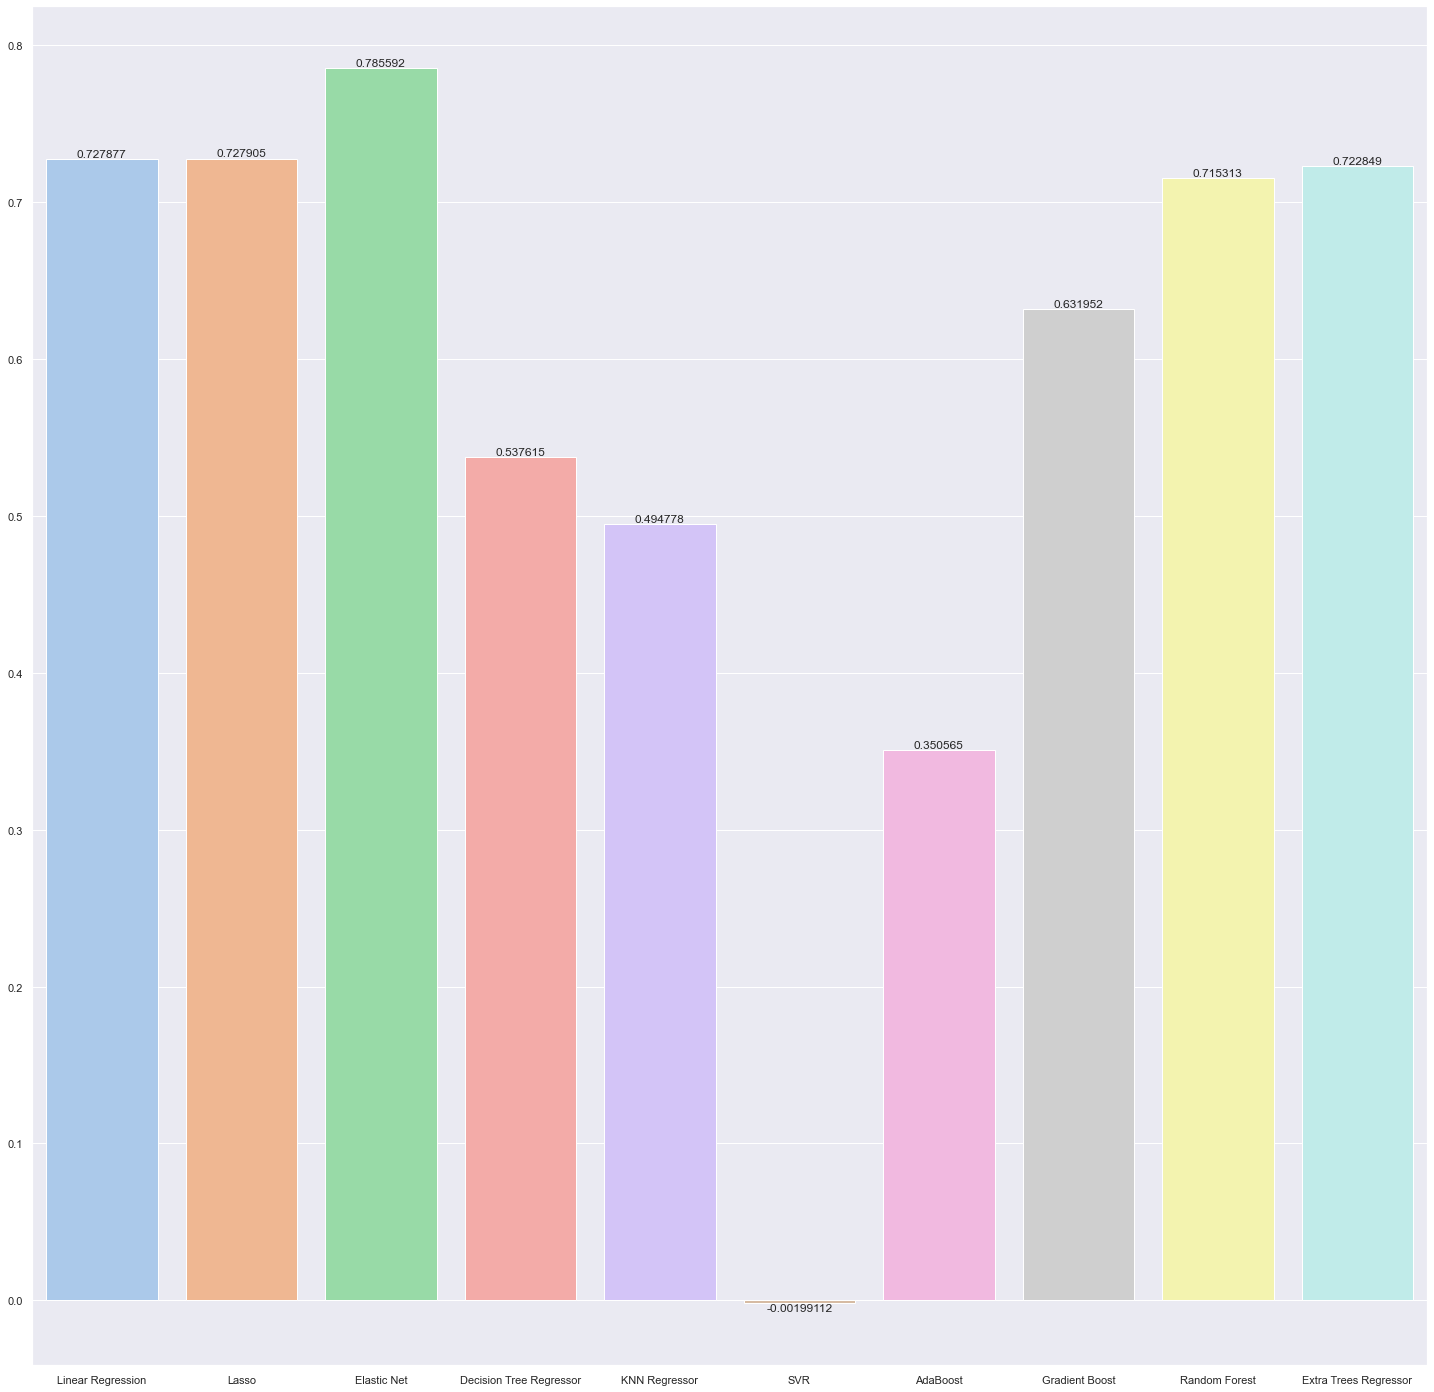

In [45]:
# Visualize model results
# Title for Model Comparison Bar Plot
title_graph = "Standardized Model Comparison:"
centered_title = title_graph.center(125)
underline = "_______________________________"
centered_underline = underline.center(125)
print(centered_title)
print(centered_underline)

# Plot model results
plt.figure(figsize = (25, 25))
standard_model_plot = sns.barplot(data = standard_model_compare)
standard_model_plot.bar_label(standard_model_plot.containers[0]); # Make bar values appear on bars

**Inference:** 
* Standardization improved the models that were already performing well, such as `ElasticNet()`, which improved to an R^2 of 0.79, while models like `RandomForestRegressor()`, `ExtrTreesRegressor()` remained uneffected. 
* `SVR()` and `AdaBoostingRegressor()` still had the worst performances with `SVR()` still having a negative R^2 model!

### 12. Hyperparameter Tuning & Cross-Validation
To test different hyperparameters, we could use a **validation set**, but since there isn't many observations in this dataset, the data will be **cross-validated**.

Model improvement framework:
1. Tune model hyperparameters, see which performs best.
2. Perform cross-validation.
3. Get R^2, MSE, MAE metrics.
4. Compare predictions to actual values via plotting. 
4. Find the most important features.

#### 12.1 Tuning KNeighborsRegressor by Hand
To get the most out of the KNN Regressor model, the main hyperparameter, the number of neighbors, can be tuned to get better results. The default is 5 (`n_neighbors = 5`). 

In this case, I will check to see if there is a value between 1 and 20 (less than or greater than default value of 5) that enhances the performance of the base KNN model. 

In [46]:
# Create a list of train scores
train_scores = []

# Create a list of test scores
test_scores = []

# Create a list different values for n_neighbors
neighbors = range(1, 21) # 1 to 20

# Setup algorithm
KNN = KNeighborsRegressor()

# Loop through different neighbor values
for i in neighbors:
    KNN.set_params(n_neighbors = i) # set neighbors value
    
    # Fit the algorithm
    KNN.fit(X_train, y_train) # Since standardization did not improve model performance, use original X_train
    
    # Update the training scores
    train_scores.append(KNN.score(X_train, y_train))
    
    # Update the test scores
    test_scores.append(KNN.score(X_test, y_test))

# Calculate max score
max_score = round(max(test_scores) * 100, 2)
max_score

67.56

                           K-Nearest Neighbors Model Results with Different Neighbor Values:                            
                                _______________________________________________________                                 
                                       Maximum KNN score on the test data: 67.56%                                       


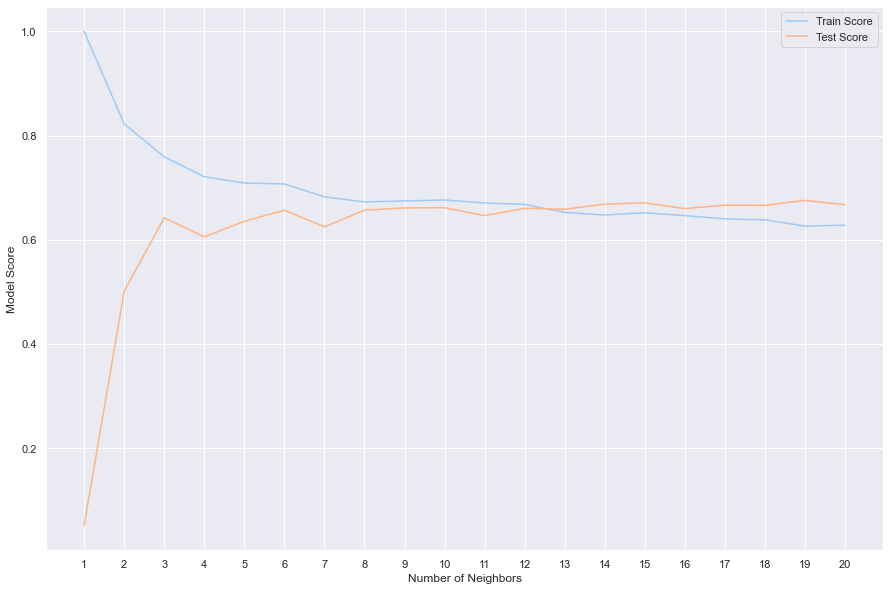

In [47]:
# Visualizing KNN scores for different # of neighbors
# Title for KNN score plot
title_all_graphs = "K-Nearest Neighbors Model Results with Different Neighbor Values:"
centered_title = title_all_graphs.center(120)
underline = "_______________________________________________________"
centered_underline = underline.center(120)
knn_best_score = "Maximum KNN score on the test data: " + str(max_score) + "%"
centered_knn_score = knn_best_score.center(120)
print(centered_title)
print(centered_underline)
print(centered_knn_score)

# Plotting the Results of Tuned KNN Models
plt.figure(figsize = (15, 10))
plt.plot(neighbors, train_scores, label = "Train Score")
plt.plot(neighbors, test_scores, label = "Test Score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of Neighbors")
plt.ylabel("Model Score")
plt.legend();

Looking at the graph, `n_neighbors = 19` seems best.

Despite tuning the number neighbors hyperparameter, the `KNN`'s model performance didn't get near what `LinearRegression()`, `Lasso()`, or the `RandomForestRegressor()`did.

For this reason, `KNN` will be dicarded, and improving the other models will be the goal.

Let's try tuning all the baseline models that scored an R^2 above 0.7 with `RandomizedSearchCV` (Not Linear Regression).

#### 12.2 Tuning models with `RandomizedSearchCV`

In [48]:
# Different Lasso Hyperparameters
lasso_reg_grid = {"alpha": np.arange(0, 1, 0.01)}

# Different ElasticNet() Hyperparameters
elastic_reg_grid = {"alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
                    "l1_ratio": np.arange(0, 1, 0.01)}

# Different RandomForestRegressor() Hyperparameters
rf_reg_grid = {"n_estimators": np.arange(10, 1000, 50),
               "max_depth": [None, 3, 5, 10],
               "min_samples_split": np.arange(5, 20, 2),
               "min_samples_leaf": np.arange(5, 15, 2)}

# Different ExtraTreesRegressor() Hyperparameters
et_reg_grid = {"n_estimators": np.arange(10, 1000, 50),
               "max_depth": [None, 3, 5, 10],
               "min_samples_split": np.arange(5, 20, 2),
               "min_samples_leaf": np.arange(5, 15, 2)}

Now let's use `RandomizedSearchCV` to try and tune the `Lasso()` model.

Through passing different hyperparameters from `lasso_reg_grid` as well as setting `n_iter = 20`. This means 20 different combinations of hyperparameters from `lasso_reg_grid` will be tested, and the best ones will be saved.

In [49]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression()
rs_lasso_reg = RandomizedSearchCV(Lasso(),
                                  param_distributions = lasso_reg_grid,
                                  cv = 5,
                                  n_iter = 20,
                                  verbose = True)

# Fit random hyperparameter search model
rs_lasso_reg.fit(X_train, y_train); # Since standardization did not improve the model, original X_train

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [50]:
# Find the best parameters
rs_lasso_reg

RandomizedSearchCV(cv=5, estimator=Lasso(), n_iter=20,
                   param_distributions={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
                   verbose=True)

In [51]:
# Evaluate the randomized search for Lasso()
rs_lasso_reg.score(X_test, y_test)

0.7278694797410592

Now we've tuned `Lasso()` using `RandomizedSearchCV`, we'll do the same for `ElasticNet()`.

In [52]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for ElasticNet()
rs_elastic_grid = RandomizedSearchCV(ElasticNet(),
                                     param_distributions = elastic_reg_grid,
                                     cv = 5,
                                     n_iter = 20,
                                     verbose = True)

# Fit random hyperparameter search model
rs_elastic_grid.fit(standard_X_train, standard_y_train); # Since standardization improved model performance

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [53]:
# Find the best parameters
rs_elastic_grid.best_params_

{'l1_ratio': 0.47000000000000003, 'alpha': 0.1}

In [54]:
# Evaluate the randomzied search for ElasticNet()
rs_elastic_grid.score(standard_X_test, standard_y_test)

0.8047289016408647

Quite an impressive 0.805 R^2 from the tuned `ElasticNet()` model! Now let's tune `RandomForestRegressor()`.

In [55]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestRegressor()
rs_rf_grid = RandomizedSearchCV(RandomForestRegressor(),
                                param_distributions = rf_reg_grid,
                                cv = 5,
                                n_iter = 20,
                                verbose = True)

# Fit random hyperparameter search model
rs_rf_grid.fit(standard_X_train, standard_y_train); # Since standardization improved model performance

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [56]:
# Find the best parameters
rs_rf_grid.best_params_

{'n_estimators': 910,
 'min_samples_split': 7,
 'min_samples_leaf': 5,
 'max_depth': 5}

In [57]:
# Evalulate the randomized search for RandomForestRegressor()
rs_rf_grid.score(standard_X_test, standard_y_test)

0.7222983888265398

A slight improvement overall for the `RandomForestRegressor()` model, the R^2 went up to 0.72 from 0.71 through randomized tuning. Let's conclude randomized search with the `ExtraTreesRegressor()` model.

In [58]:
# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for ExtraTreesRegressor()
rs_et_grid = RandomizedSearchCV(ExtraTreesRegressor(),
                                param_distributions = rf_reg_grid,
                                cv = 5,
                                n_iter = 20,
                                verbose = True)

# Fit random hyperparameter search model
rs_et_grid.fit(standard_X_train, standard_y_train); # Standardization did not improve model performance, so it data transformation does not matter

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [59]:
# Find the best parameters
rs_et_grid.best_params_

{'n_estimators': 910,
 'min_samples_split': 7,
 'min_samples_leaf': 5,
 'max_depth': 5}

In [60]:
# Evaluate the randomized search for ExtraTreesRegressor()
rs_et_grid.score(standard_X_train, standard_y_train)

0.7903731673498184

Yet another model has achieved an impressive improvement! The R^2 of the tuned ExtraTreesRegressor() model went up to 0.79 from 0.73 through `RandomizedSearchCV`. 

**Conclusions from `RandomizedSearchCV`:**
* `RandomizedSearchCV` provided the same R^2 (R^2 = 0.7278694797410592) as the base model with the specified hyperparameters for `Lasso()`.
* `RandomizedSearchCV` provided a slight improvement in R^2 (R^2 = 0.7222983888265398) with the specified hyperparameters for `RandomForestRegressor()` when compared to the base model (R^2 = 0.709621).
* `RandomizedSearchCV` provided a significant increase in R^2 (R^2 = 0.7903731673498184) with the specified hyperparameters for `ExtraTreesRegressor()` when compared to the base model (R^2 = 0.722849). 
* `RandomizedSearchCV` provided a significant increase in R^2 (R^2 = 0.8047289016408647) with the specified hyperparameters for `ElasticNet()` when compared to the base model (R^2 = 0.667288). 

#### 12.3 Tuning models with `GridSearchCV`
We will continue to improve our `ElasticNet()` and `ExtraTreesRegressor()` models to ensure the best predictions with `GridSearchCV` as they continue to provide better results over the other models.

In [61]:
# Setup grid hyperparameter search for ElasticNet() using same grid from randomizedsearchCV
gs_elastic_reg = GridSearchCV(ElasticNet(),
                              param_grid = elastic_reg_grid,
                              cv = 5,
                              verbose = True)

# Fit grid hyperparameter search model
gs_elastic_reg.fit(standard_X_train, standard_y_train);

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


In [62]:
# Check the best parameters
gs_elastic_reg.best_params_

{'alpha': 0.1, 'l1_ratio': 0.71}

In [63]:
# Evaluate the model
gs_elastic_reg.score(standard_X_test, standard_y_test)  # Since standardization improved model performance

0.7805747049199566

In this case, we get a slightly lower performance with the best parameters from the hyperparameter grid on the `ElasticNet()` model with `GridSearchCV`. We will stick with the best model acquired through `randomizedsearchCV` earlier for the `ElasticNet()` model. 

In [65]:
# Different ExtraTreesRegressor() hyperparameters
gs_et_grid = {'n_estimators': [100, 200, 500],
              'max_depth': [None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_split': [6],
              'min_samples_leaf': [1, 2]}

# Setup grid hyperparameter search for ExtraTreesRegressor()
gs_et_reg = GridSearchCV(ExtraTreesRegressor(),
                         param_grid = gs_et_grid,
                         cv = 5,
                         verbose = True)

# Fit grid hyperparameter search model
gs_et_reg.fit(standard_X_train, standard_y_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [66]:
# Check the best parameters
gs_et_reg.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 100}

In [67]:
# Evaluate the model
gs_et_reg.score(standard_X_test, standard_y_test)

0.720296364555316

In this case, we get a slightly lower performance with the best parameters from the hyperparameter grid on the `ExtraTreesRegressor()` model with `GridSearchCV`. This is because we had less overall hyperparameters. Increasing hyperparameters can provide a better model with `GridSearchCV`, but this would demand too much computing power. We will stick with the best model acquired through `randomizedsearchCV` earlier for the `ExtraTreesRegressor()` model. 

**Finalizing the best machine learning model:** 

Through hyperparameter tuning, we found that the `ElasticNet()` model achieved the an R^2 of approximately 0.8047, which was the highest score amongst the best performing models. This model will be leveraged to compare with the **Spatial Regression** model in the ladder parts of the analysis.

### 13. Evaluation
Let's assess prediction metrics beyond just R^2. 

Metrics:
* MSE - `mean_squared_error()`
* MAE - `mean_absolute_error()`
* RMSE - `mean_squared_error(squared = False)`

#### 13.1 Predictions

In [70]:
# Make predictions on test data
y_preds = rs_elastic_grid.predict(standard_X_test)

In [71]:
# Check predictions
y_preds

array([573615.10602171, 440183.02677996, 471843.54916347, 368137.65880393,
       349695.69078499, 452036.1933435 , 220544.71479416, 254164.08483335,
       370551.68324758, 471414.16466748, 418289.00082203, 303201.97875066,
       511392.19665253, 338563.11824043, 419536.68481082, 375021.92424668,
       456421.07525922, 480290.9235701 , 216160.11427692, 299681.23836185,
       479623.86004234, 429245.75340883, 601430.97064191, 367038.875601  ,
       304141.54571605, 791086.81043107,  82723.56315996, 396255.11217621,
       349708.47358944, 471137.17138143, 374842.11315422, 678999.17296567,
       284615.02248344, 457597.99208392, 362805.70208801, 264661.48969482,
       547490.51604584, 503260.90123517])

In [72]:
# Check test set
y_test

185    500508.0
78     400335.0
55     575117.0
137    348504.0
161    250092.0
15     481134.0
75     259198.0
154    200609.0
122    400077.0
175    428740.0
158    448844.0
42     349709.0
165    473595.0
30     349820.0
51     420057.0
16     325273.0
166    375913.0
177    400899.0
85     200338.0
19     324250.0
124    500591.0
118    448954.0
5      674299.0
148    449019.0
24     279387.0
152    696904.0
9      179211.0
138    349627.0
135    348767.0
162    399746.0
18     320642.0
172    649737.0
76     250714.0
66     400796.0
68     295594.0
35     268392.0
97     474054.0
145    524399.0
Name: houseValue, dtype: float64

#### 13.3 Cross-Validated Metrics
We'll obtain more precise metrics through cross-validation. This will be done by using the best model (`ElasticNet()`) with the best hyperparameters and using `cross_val_score()` along with various `scoring` parameter values.

Checking the best hyperparameters again and instantiating a regressor with the the tuned `ElasticNet()`model:

In [73]:
# Best parameters through hyperparameter tuning on ElasticNet()
rs_elastic_grid.best_params_

{'l1_ratio': 0.47000000000000003, 'alpha': 0.1}

In [76]:
# Instantiate best model with best hyperparameters (found with RandomizedSearchCV)
reg = ElasticNet(l1_ratio = 0.47000000000000003, 
                 alpha = 0.1)

Now that we have an instantiated regressor, let's find some cross-validated metrics.

In [81]:
# Cross-validated r^2 score
cv_r2 = cross_val_score(reg,
                        standard_X,
                        y,
                        cv = 5, # 5-fold cross-validation
                        scoring = "r2") # r^2 as scoring
cv_r2

array([0.83056037, 0.63032727, 0.85005409, 0.73779074, 0.52479657])

Since there are 5 metrics, we'll take the average. 

In [82]:
cv_r2 = np.mean(cv_r2)
cv_r2

0.7147058072360789

This will be done for the other regression metrics.

In [102]:
# Average cross-validated MSE score
cv_mse = abs(np.mean(cross_val_score(reg,
                                     standard_X,
                                     y,
                                     cv = 5,
                                     scoring = "neg_mean_squared_error")))
cv_mse

6020326838.140182

In [103]:
# Average cross-validated MAE score
cv_mae = abs(np.mean(cross_val_score(reg,
                                 standard_X,
                                 y,
                                 cv = 5,
                                 scoring = "neg_mean_absolute_error")))
cv_mae

57070.99250814138

In [104]:
# Average cross-validated RMSE score
cv_rmse = abs(np.mean(cross_val_score(reg,
                                   standard_X,
                                   y,
                                   cv = 5,
                                   scoring = "neg_root_mean_squared_error")))
cv_rmse

73761.67355843468

In [188]:
# Visualizing cross-validated metrics
cv_metrics = pd.DataFrame({"R^2": cv_r2,
                           "MSE": cv_mse,
                           "MAE": cv_mae,
                           "RMSE": cv_rmse},
                          index = ["Scores"])
cv_metrics

,R^2,MSE,MAE,RMSE
Scores,0.71,6.02e+09,57070.99,73761.67


In [187]:
cv_metrics_interest = pd.DataFrame({"MAE": cv_mae,
                                    "RMSE": cv_rmse},
                                    index = ["Scores"])
cv_metrics_interest

,MAE,RMSE
Scores,57070.99,73761.67


Since the MSE is biased towards the higher values, **RMSE** will be the chosen over it as an evaluation metric because the units are at the same scale as the target variable (`houseValue`). 

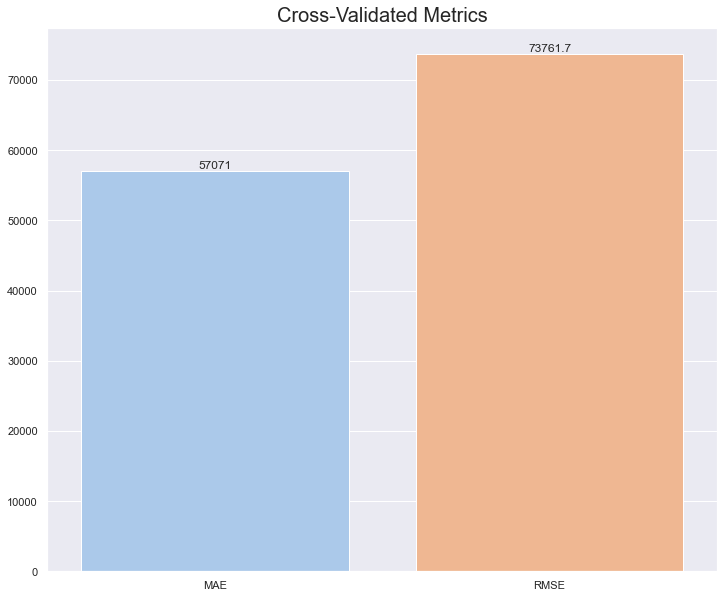

In [113]:
# Plotting Bar Graph for Cross-Validated Metrics (MAE & RMSE)
plt.figure(figsize = (12, 10))
cv_metrics_plot = sns.barplot(data = cv_metrics_interest)
cv_metrics_plot.set_title("Cross-Validated Metrics", fontsize = 20)
cv_metrics_plot.bar_label(cv_metrics_plot.containers[0]); # Make bar values appear on top of bars

Nice! We have achieved an MAE of 57071, and an RMSE of 73761.7 for the difference between the predictions, and the actual house prices. Since this is a house price prediction problem, we want to amplify the outlier predictions as being off in house prices is not desirable for accurate prediction. Therefore, selecting **RMSE** as the primary metric of evaluation will be the key for this analysis. However, since we are going to be comparing the score of the best machine learning model, and the spatial regression model, we will also **retain the R^2 values** for comparison. 

### 14. Feature Importance
Which features contribute most to a model predicting Hamilton's house prices?

In [115]:
# Fit an instance of ElasticNet()
reg.fit(standard_X_train, standard_y_train);

In [117]:
# Check coefficients
reg.coef_

array([ -6664.45210647,   7294.48859808,  76760.82500597, -73980.12870663,
        81041.42716056, -22936.82119382,   4054.37844015,   -548.92420883])

In [118]:
# Match features to columns in dataframe
feature_importance_s = pd.Series(reg.coef_, index = X.columns)

In [119]:
# Converting series to dataframe
feature_importance_df = feature_importance_s.to_frame('value').T
feature_importance_df

,priv_dwellings_by_rooms,major_repairs,monthly_housing_costs,percent_mortgage,income_after_tax,avg_house_size,population,land_area
value,-6664.45,7294.49,76760.83,-73980.13,81041.43,-22936.82,4054.38,-548.92


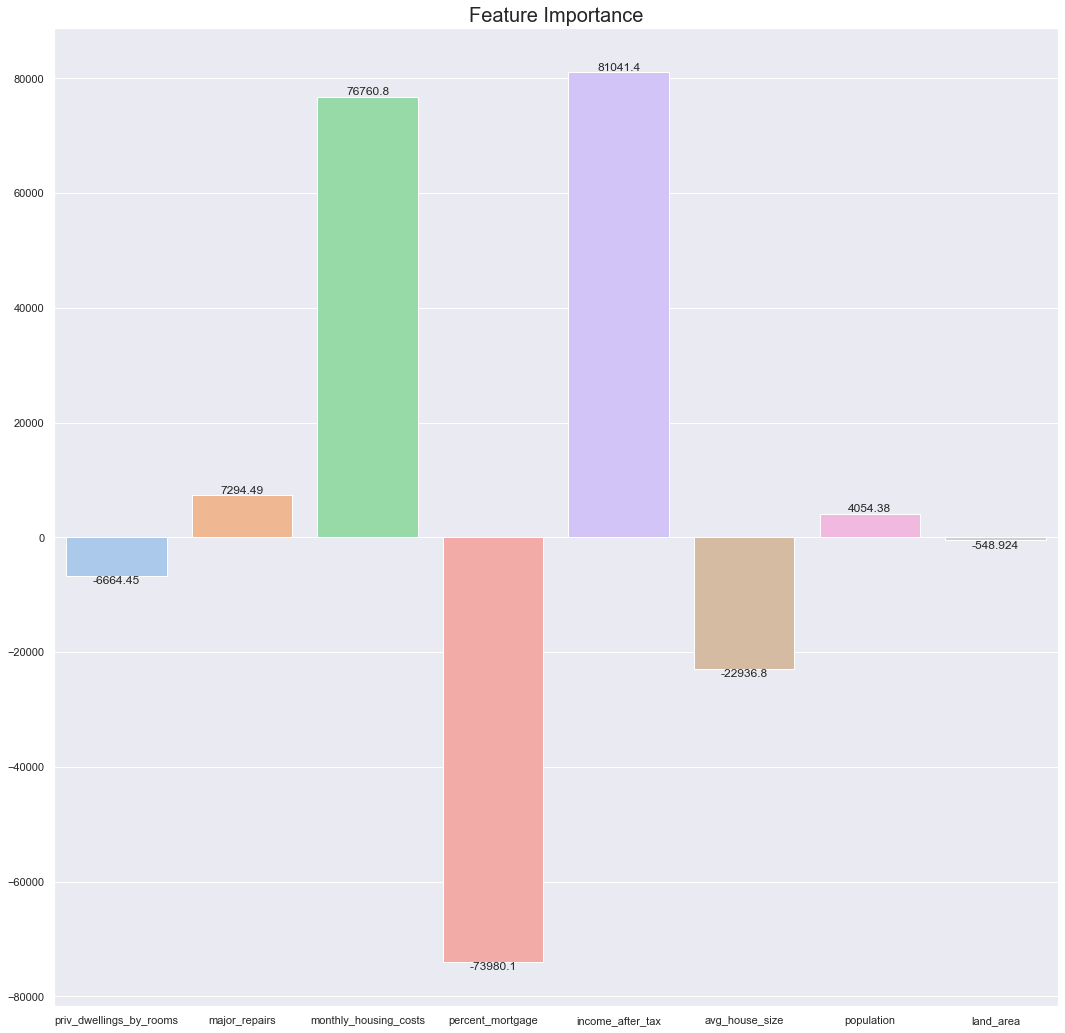

In [126]:
# Visualize feature importance
plt.figure(figsize = (18, 18))
feature_importance_plot = sns.barplot(data = feature_importance_df)
feature_importance_plot.set_title("Feature Importance", fontsize = 20)
feature_importance_plot.bar_label(feature_importance_plot.containers[0]); # Make bar values appear on top of bars

**Conclusions from Feature Importance:**
* `monthly_housing_costs` and `income_after_tax` are by far the most important features for determining/predicting Hamilton's house prices. This is likely because people living in larger houses tend to earn more and have more monthly costs. Hence, the house prices are likely to increase or decrease based on the income and monthly housing costs across the city's census tracts (`CTUID` feature from original dataframe).
* `percent_mortage` and `avg_house_size` are the least important features for determining/predicting Hamilton's house prices. Their low coefficient values are likely due to the fact that houses throughout the city have no relationship between how many people are living in them, and their price. Across the census tracts that comprise of the city, there is a large variation between the prices, and the number of people living in the home. Some `CTUIDs` (census tracts) have lower priced homes with more people living in them while others have less people living in the home, but the house's price is quite high. In addition, mortgage is practically irrelevant to the predicting a house's price as this feature relates more to an individual's income. We cannot make good predictions on a house price given the percentage of individuals with mortgages in a `CTUID` (census tracts). 

### 15. Saving Models
The best model will be saved using the **joblib** library.

In [127]:
from joblib import dump

# Save model to file
dump(reg, filename = "rs_elastic_net_reg_house_price_prediction.joblib")

['rs_elastic_net_reg_house_price_prediction.joblib']

### 16. Spatial Regression
Since we have completed an end-to-end machine learning project on house price prediction for Hamilton, ON, it is now time to dive deeper into the potential insights that a spatial regression model would provide over the machine learning models developed earlier. 

> **Research Question:** Will the Spatial Regression model provide better predictions than the Mahcine Learning Model?:

#### 16.1 Exploring & Processing Spatial Data

In [128]:
# Inspect spatial data
df_copy.head(5)

,CTUID,houseValue,geometry,priv_dwellings_by_rooms,major_repairs,monthly_housing_costs,percent_mortgage,income_after_tax,avg_house_size,population,land_area
0,5.37e+06,420276.0,"POLYGON ((-79.85586 43.18790, -79.85592 43.187...",1390,25,1612,72.3,78976,3.3,4566,1.97
1,5.37e+06,601551.0,"POLYGON ((-79.94562 43.16920, -79.94637 43.167...",685,75,1460,55.5,87211,3.0,7821,27.69
2,5.37e+06,525073.0,"POLYGON ((-79.89977 43.33088, -79.89977 43.330...",2505,50,1883,78.3,98624,2.8,5879,2.37
3,5.37e+06,524777.0,"POLYGON ((-79.89286 43.32909, -79.89226 43.328...",1315,25,1705,63.5,94948,3.0,8605,10.22
4,5.37e+06,400617.0,"POLYGON ((-79.85362 43.19320, -79.85380 43.192...",2050,35,1513,66.7,80576,3.2,6556,1.64


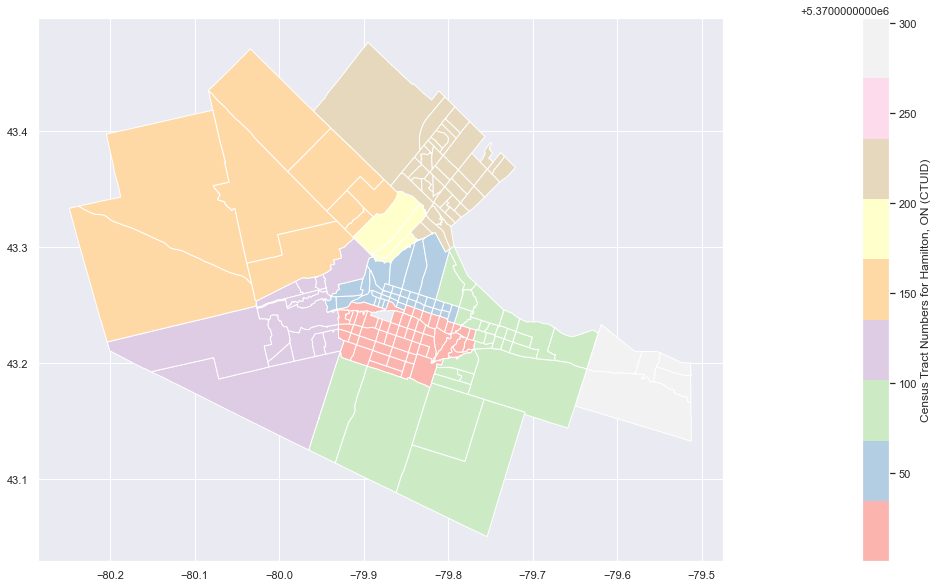

In [139]:
# Mapping Hamilton, ON by CTUID
df_copy.plot(column = "CTUID",
             legend = True,
             figsize = [50, 10],
             legend_kwds = {'label': "Census Tract Numbers for Hamilton, ON (CTUID)"},
             cmap = "Pastel1");

In [143]:
# Explanatory variables
explanatory_vars = ["priv_dwellings_by_rooms", "major_repairs", "monthly_housing_costs", "percent_mortgage",
                    "income_after_tax", "avg_house_size", "population", "land_area"]

In [144]:
# Logarithmic transformation of target (houseValue)
df_copy["log_houseValue"] = np.log(df_copy["houseValue"] + 0.000001)

#### 16.2 Spatial Regression Modelling 

##### 16.2.1 Baseline Regression Model
For the spatial regression modelling, we will develop a **baseline OLS model** using PySAL without a **spatial weights matrix**, which would emphasize a connection between an observation and its n-nearest neighbors. 

In [156]:
# Baseline Spatial Regression model without spatial weights
baseline_sp_reg = spreg.OLS(df_copy[["log_houseValue"]].values, df_copy[explanatory_vars].values, 
               name_y = "log_houseValue", name_x = explanatory_vars);

In [157]:
# Acquire model summary table
print(baseline_sp_reg.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :log_houseValue                Number of Observations:         187
Mean dependent var  :     12.9068                Number of Variables   :           9
S.D. dependent var  :      0.3569                Degrees of Freedom    :         178
R-squared           :      0.8410
Adjusted R-squared  :      0.8338
Sum squared residual:       3.767                F-statistic           :    117.6715
Sigma-square        :       0.021                Prob(F-statistic)     :   6.378e-67
S.E. of regression  :       0.145                Log likelihood        :      99.748
Sigma-square ML     :       0.020                Akaike info criterion :    -181.496
S.E of regression ML:      0.1419                Schwarz criterion     :    -152.416

---------------------------------------------------------------------------

##### 16.2.2 Spatially Lagged Exogenous Regression Model

To develop the spatially lagged exogenous regression model, we will be spatially lagging the explanatory variable that influences the price of a home at a given location the most. From the baseline OLS model, it is apparent that `monthly_housing_costs` influences the price of the home most based on the coefficients of the OLS model. 

In [164]:
# Create spatial weights
w_costs = weights.KNN.from_dataframe(df_copy, k = 5) # Setting weights to 5 for consistency
# Adding Spatial Lag based on monthly_housing_costs
spatial_lagged_df = df_copy.assign(w_costs = weights.spatial_lag.lag_spatial(w_costs, df_copy['monthly_housing_costs'].values))
spatial_lagged_df.head(5)

,CTUID,houseValue,geometry,priv_dwellings_by_rooms,major_repairs,monthly_housing_costs,percent_mortgage,income_after_tax,avg_house_size,population,land_area,log_houseValue,w_costs
0,5.37e+06,420276.0,"POLYGON ((-79.85586 43.18790, -79.85592 43.187...",1390,25,1612,72.3,78976,3.3,4566,1.97,12.95,6821.0
1,5.37e+06,601551.0,"POLYGON ((-79.94562 43.16920, -79.94637 43.167...",685,75,1460,55.5,87211,3.0,7821,27.69,13.31,7210.0
2,5.37e+06,525073.0,"POLYGON ((-79.89977 43.33088, -79.89977 43.330...",2505,50,1883,78.3,98624,2.8,5879,2.37,13.17,6995.0
3,5.37e+06,524777.0,"POLYGON ((-79.89286 43.32909, -79.89226 43.328...",1315,25,1705,63.5,94948,3.0,8605,10.22,13.17,7062.0
4,5.37e+06,400617.0,"POLYGON ((-79.85362 43.19320, -79.85380 43.192...",2050,35,1513,66.7,80576,3.2,6556,1.64,12.90,6856.0


In [165]:
# Updating explanatory variables
explanatory_vars = explanatory_vars + ["w_costs"]

Now, the same OLS model can be trained onto the data with the addition of the spatially lagged `monthly_housing_costs` features as `w_costs`.

In [170]:
# Lagged exogenous regression model with lagged feature and weights
sp_lagged_exogenous_reg = spreg.OLS(spatial_lagged_df["log_houseValue"].values, spatial_lagged_df[explanatory_vars].values,
                                    name_y = "log_houseValue", name_x = explanatory_vars)

In [171]:
# Model summary table
print(sp_lagged_exogenous_reg.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :log_houseValue                Number of Observations:         187
Mean dependent var  :     12.9068                Number of Variables   :          10
S.D. dependent var  :      0.3569                Degrees of Freedom    :         177
R-squared           :      0.8548
Adjusted R-squared  :      0.8474
Sum squared residual:       3.441                F-statistic           :    115.7428
Sigma-square        :       0.019                Prob(F-statistic)     :   2.485e-69
S.E. of regression  :       0.139                Log likelihood        :     108.223
Sigma-square ML     :       0.018                Akaike info criterion :    -196.445
S.E of regression ML:      0.1357                Schwarz criterion     :    -164.134

---------------------------------------------------------------------------

#### 16.3 Prediction & Evaluation of Spatial Models
Generally speaking, house prices are **drived heavily by location**, which is a spatial attribute. 

The use of spatial models is likely going to improve prediction accuracy.
We will compute the **MSE** as the evaluation metric for the spatial regression models just like the machine learning models to compare their results.

This will explicity determine if spatial models are better than non-spatial machine learning models for house price predictions where spatial attributes play a role in determining house prices.

In [175]:
spatial_reg_scores = pd.Series({"OLS (No-Weights)": mean_squared_error(df_copy["log_houseValue"], baseline_sp_reg.predy.flatten()),
                                "Lagged OLS": mean_squared_error(df_copy["log_houseValue"], sp_lagged_exogenous_reg.predy.flatten())
                               })
spatial_reg_scores.sort_values()

Lagged OLS          0.02
OLS (No-Weights)    0.02
dtype: float64

We can see **no improvement** in the MSE of the spatial OLS model by lagging the best feature and adding a weight matrix, but when we compare the R^2 and adjuated of the spatially lagged OLS model to the OLS without weights or lag, we can see a slightly improvement in model performance.

### 17. Model Comparison

We will be comparing the **R^2 values** of the spatial regression, and the best performing machine learning model (`ElasticNet()`) to compare and see which model performed better. From this comparision, we will be able to conclude draw a conclusion on if spatial attributes play an attribute in house price prediction. 

In [176]:
# Cross-validated R^2 of tuned ElasticNet() model
cv_r2

0.7147058072360789

In [179]:
# R^2 of ElasticNet() model obtained through standardized train/test without cross-validation
elasticnet_r2 = rs_elastic_grid.score(standard_X_test, standard_y_test)
elasticnet_r2

0.8047289016408647

In [180]:
# R^2 of spatially lagged linear model from model summary table
sp_lagged_reg_r2 = 0.8548
sp_lagged_reg_r2

0.8548

In [184]:
# Visualizing spatial and non-spatial r2 scores
models_r2 = pd.DataFrame({"Elastic Net": elasticnet_r2,
                           "Cross-Validated Elastic Net": cv_r2,
                           "Spatially Lagged OLS": sp_lagged_reg_r2},
                           index = ["R^2"])
models_r2

,Elastic Net,Cross-Validated Elastic Net,Spatially Lagged OLS
R^2,0.8,0.71,0.85


**Conclusions from Model Comparisions**:
* The Spatially Lagged OLS model achieved a **higher R^2 (0.85)** than the both the cross-validated Elastic Net model, and the tuned Elastic Net. Although the tuned Elastic Net model achieved an **R^2 value of 0.8**, this was only acquired through exhaustive hyperparameter tuning, and compared with other non-spatial machine learning models. The spatially lagged OLS achieved a 0.85 R^2 with just the addition of a spatially lagged feature (the feature that influenced the house prices the most).


* The inclusion of **spatially lagged features provides a more accurate model** for house price prediction when space plays a role.


* Spatial models can provide better predictions than non-spatial machine learning models for house price prediction because house prices are heavily dependent upon location. 


* Therefore, for house price prediction problems, it is a good idea to include **spatial regression models** in addition to the non-spatial machine learning models for prediction. This is because location/geography plays a big role in influencing the prices of homes. Hence, the prices of Hamilton houses across census tracts are **spatially dependent**. 

**Limitations in Results**:
* The dataset is unfortunately not large enough to reach solid conclusions with accurate predictions. More housing data will be required as well as far more features to truly develop accurate models.


* In addition, the spatial OLS model was developed using log house prices (target variable) while the machine learning models were not trained and tested on log house prices (the target not transformed using log). This means that we were unable to compare the RMSE, MSE or MAE metrics of the models as they were computed on different scales. Training the machine learning models with log house prices would be the next step to see which models provided lower RMSE and MAE values. 